### Modify the HK03 rheology

Author: Haoyuan Li

Aug 21th, 2023

Here I describe how to modify the rheology published by Hirth and Kohlstedt 2003.
I take the same steps in Magali's document and add additional steps to both modify the E and V values properly and convert them to the parameters in an ASPECT .prm file.


#### system requirments

System requirement: this notebook needs to be run in place (in a subdirectory to the aspectLib package), and the conda environment for aspectLib needs to be selected as the kernel.

This notebook first imports a few modules and defines several utility functions.
The actual process starts from code block 6.

#### Import the modules

There is dependence imported by the syntax in the next block:
    
    import shilofue.{module} as {alias}  

In [1]:
import json
import os
import sys
import math
import argparse
import numpy as np
from scipy.special import erf
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D
from shutil import rmtree, copy
from matplotlib import pyplot as plt
from matplotlib import gridspec, cm
from matplotlib import patches as mpatches 

plt.style.use('publication_lhy11009')

R = 8.314

# directory to the aspect Lab
ASPECT_LAB_DIR = os.environ['ASPECT_LAB_DIR']
RESULT_DIR = os.path.join(ASPECT_LAB_DIR, 'results')

sys.path.append(os.path.join(ASPECT_LAB_DIR))
import shilofue.PlotDepthAverage as PDAver
import shilofue.FlowLaws as FlowLaws
import shilofue.ParsePrm as ParsePrm
import shilofue.ThermalModel as TModel
import shilofue.Rheology as Rheology

# import utilities in subdirectiory
sys.path.append(os.path.join(ASPECT_LAB_DIR, 'utilities', "python_scripts"))
import Utilities


#### Utility functions

The first function computes the prefactor in the rheology with other variables fixed in a flow law (p, r, n, E, V). 
The strain rate and the stress need to be assigned.

    CreepComputeAfromSS(creep, strain_rate, stress, P, T, d=1e4, Coh=1e3, **kwargs)

The second function updates the value of E, V in an existing creep flow law by pinpointing to experiments.
In this process, a stress value needs to be assigned to pinpoint the results from the original flow law.

    RheologyUpdateEV(creep, stress, P, T, d, Coh, **kwargs)
    

In [2]:
def CreepComputeAfromSS(creep, strain_rate, stress, P, T, d=1e4, Coh=1e3, **kwargs):
    """
    Compute the prefactor in the rheology with other variables in a flow law (p, r, n, E, V).
    The strain rate and the stress are assigned and formulated by the flow law:
    B = A * d**(-p) * Coh**r
    strain_rate = F * B *stress**n * np.exp(-(E + P * V) / (R * T))
    Note that the formulation with Coh and fH2O (fugacity) are the same thus one can use either Coh or fH2O in the computation.
    Inputs:
        creep: a set of variables including p, r, n, E, V
        strain_rate: the strain rate, unit: s^-1
        stress: the stress, unit: MPa
        P: The pressure, unit: Pa
        T: The temperature, unit: K
        d: The grain size, unit: mu m
        Coh: either the Coh value in unit of H / 10^6 Si or the water fugacity in unit of MPa
    Returns 
        A: The prefactor, unit: 
    """
    p = creep['p']
    r = creep['r']
    n = creep['n']
    E = creep['E']
    V = creep['V']
    # compute value of F(pre factor)
    use_effective_strain_rate = kwargs.get('use_effective_strain_rate', False)
    if use_effective_strain_rate:
        F = 1 / (2**((n-1)/n)*3**((n+1)/2/n))
    else:
        F = 1.0
    # calculate B
    B = (F*strain_rate/stress)**n * strain_rate**(1-n) * np.exp((E+P*V)/(R*T))

    A = B * d**p * Coh**(-r)
    return A


def RheologyUpdateEV(creep, stress, P, T, d, Coh, **kwargs):
    '''
    Update the value of E, V on an existing creep flow law
    Assign specific conditions to pinpoint the results from the original flow law
    Inputs:
        creep: a set of variables including p, r, n, E, V, the E, V values are used as defaults.
        strain_rate: the strain rate, unit: s^-1
        stress: the stress, unit: MPa
        P: The pressure, unit: Pa
        T: The temperature, unit: K
        d: The grain size, unit: mu m
        Coh: either the Coh value in unit of H / 10^6 Si or the water fugacity in the unit of MPa

        kwargs:
            E: a new activation energy
            V: a new activation volume
    
    Returns:
        creep_new: a new set of variables after updating.
    '''
    creep_new = creep.copy()
    E = kwargs.get("E", None) 
    V = kwargs.get("V", None) 

    # update the V and E values
    if E is not None:
        creep_new['E'] = E
    if V is not None:
        creep_new['V'] = V
    
    # pinpoint the (strain_rate, stress) with the condition given 
    strain_rate = Rheology.CreepStrainRate(creep, stress, P, T, d, Coh)
    print("%s: update E, V value with condition stress = %.4e, strain rate = %.4e." % (Utilities.func_name(), stress, strain_rate))
    
    # compute a new A value that fits the pinpointed results
    A = CreepComputeAfromSS(creep_new, strain_rate, stress, P, T, d, Coh)
    creep_new['A'] = A
    return creep_new

A third function would check the newly fitted rheology by plotting over a range of conditions and comparing with the figures from publications (Hirth and Kohlstedt, 2003; Mei and Kohlstedt, 2000a, 2000b).

    RefitHK03(rheology_dict, _name, o_path)

Then the previous steps are combined into one function:

    RefitHK03Combined(rheology_dict, **kwargs)

In this function, new values of activation energys and activation volumes are assigned.
Then it refits the prefactors with the experimental conditions:

    stress = 50.0 # MPa
    P = 100.0e6 # Pa
    T = 1250.0 + 273.15 # K
    fh2o = 100.0 # MPa
    d = 15.0 # mu m

At last, a new composite rheology is produced and returned by the function.

#### First plot the fit to the original HK03 rheology

We first plot the fit to the original HK03 rheology.
The fit is generated with the published figures in the original paper.

The first two figures are fits to the Mei and Kohstedt 2000 paper
The figure on the second raw is a fit to the composite flow law of the HK 03 paper.
The figure on the third raw are fits to the diffusion and dislocation flow law (wet), respectively
The figure on the 4th raw is a fit to the dependence on Coh from the HK 03 paper.

The results show general fit to the HK03 data, except for the dislocation flow law (wet)

RefitHK03: save figure /home/lochy/ASPECT_PROJECT/aspectLib/results/HK03_f.pdf


/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


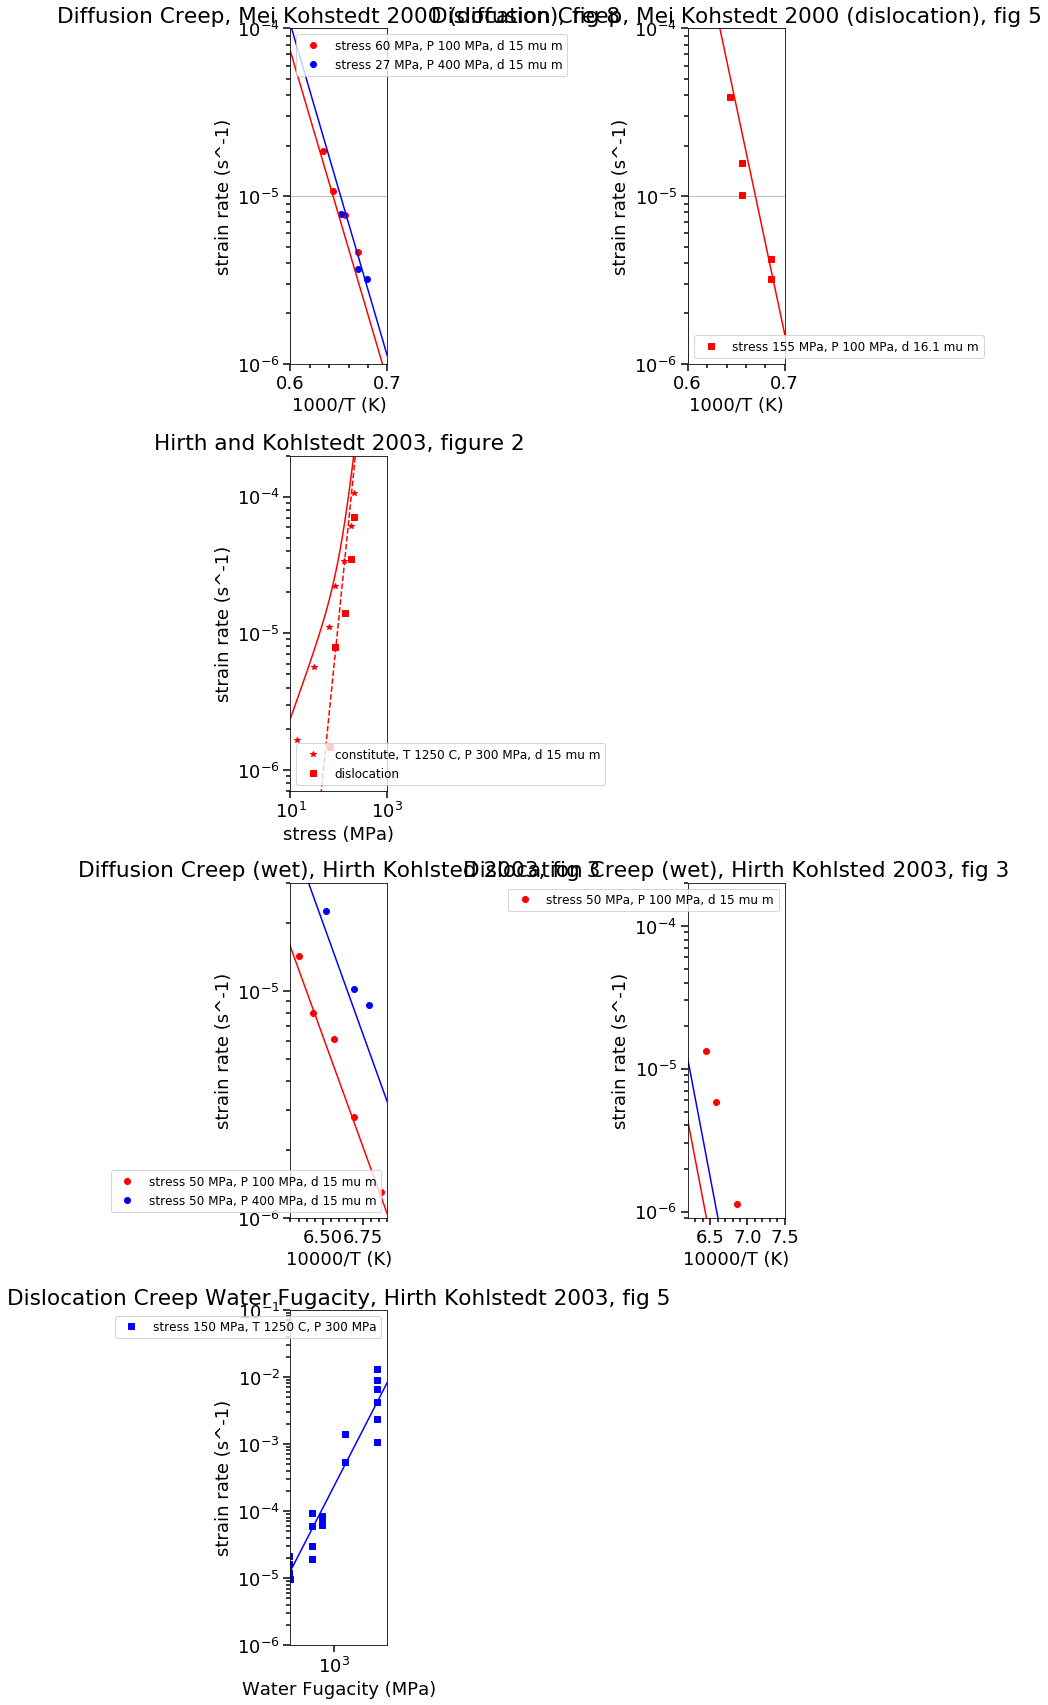

In [3]:
# read the parameters from HK 03.
# water is in the water fugacity
diffusion_creep, dislocation_creep = Rheology.GetRheology("HK03_f", use_coh=False)
rheology_dict = {'diffusion': diffusion_creep, 'dislocation': dislocation_creep}

# plot the old result
Rheology.RefitHK03(rheology_dict, "HK03_f", RESULT_DIR, plot_title=False)

#### Modify the HK 03 rheology with a different activation energy or activation volume

The main workflow starts here by first assigning the deviation of the activation energies and activation volumes.

    dE_diff = 
    ...

One can also change the values of activation energy and volume directly, as those are what the following parts of the code needs.    

    E_diff =
    ...

RefitHK03: save figure /home/lochy/ASPECT_PROJECT/aspectLib/results/HK03Modify_diff_375_23_disl_520_24/HK03_f.pdf
RheologyUpdateEV: update E, V value with condition stress = 5.0000e+01, strain rate = 4.7173e-06.
RheologyUpdateEV: update E, V value with condition stress = 5.0000e+01, strain rate = 4.3816e-07.
rheology_new_dict:  {'diffusion': {'A': 27702795.221323438, 'p': 3.0, 'r': 1.0, 'n': 1.0, 'E': 375000.0, 'V': 2.3e-05, 'use_f': 1, 'wet': 1}, 'dislocation': {'A': 1625.4701383129482, 'p': 0.0, 'r': 1.2, 'n': 3.5, 'E': 520000.0, 'V': 2.4e-05, 'use_f': 1, 'wet': 1}}
RefitHK03: save figure /home/lochy/ASPECT_PROJECT/aspectLib/results/HK03Modify_diff_375_23_disl_520_24/HK03_f_refit.pdf


/home/lochy/anaconda3/envs/aspectLib/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


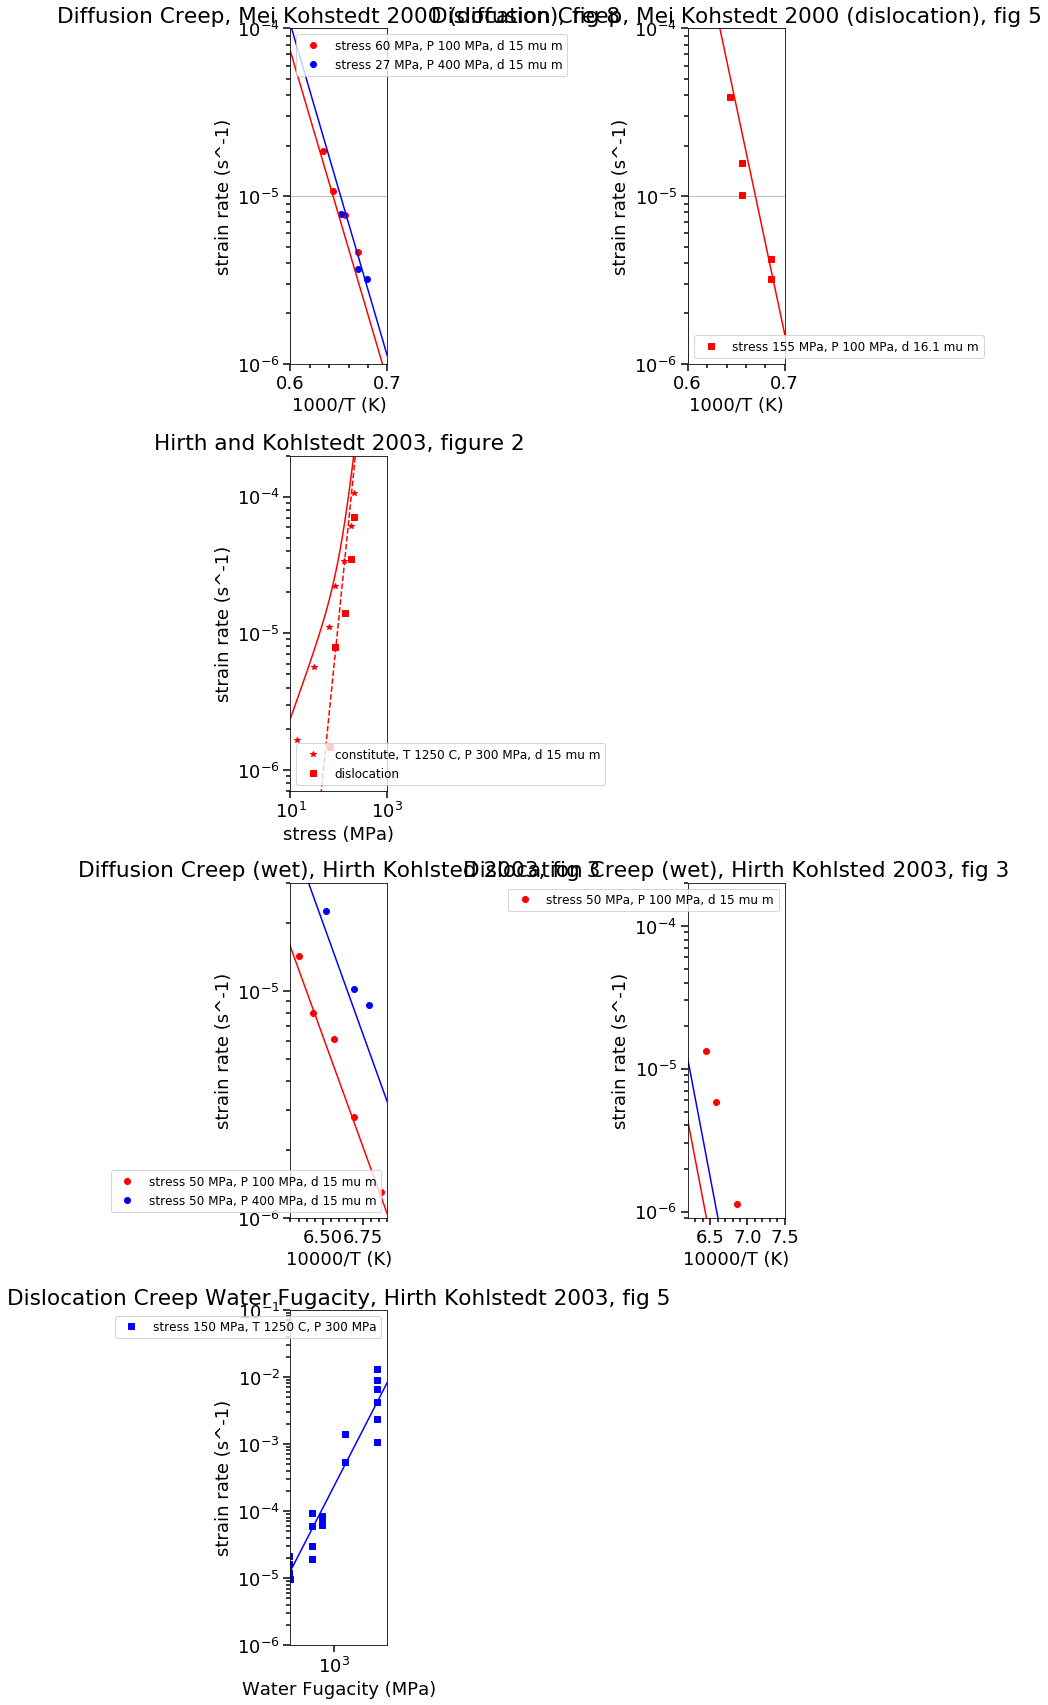

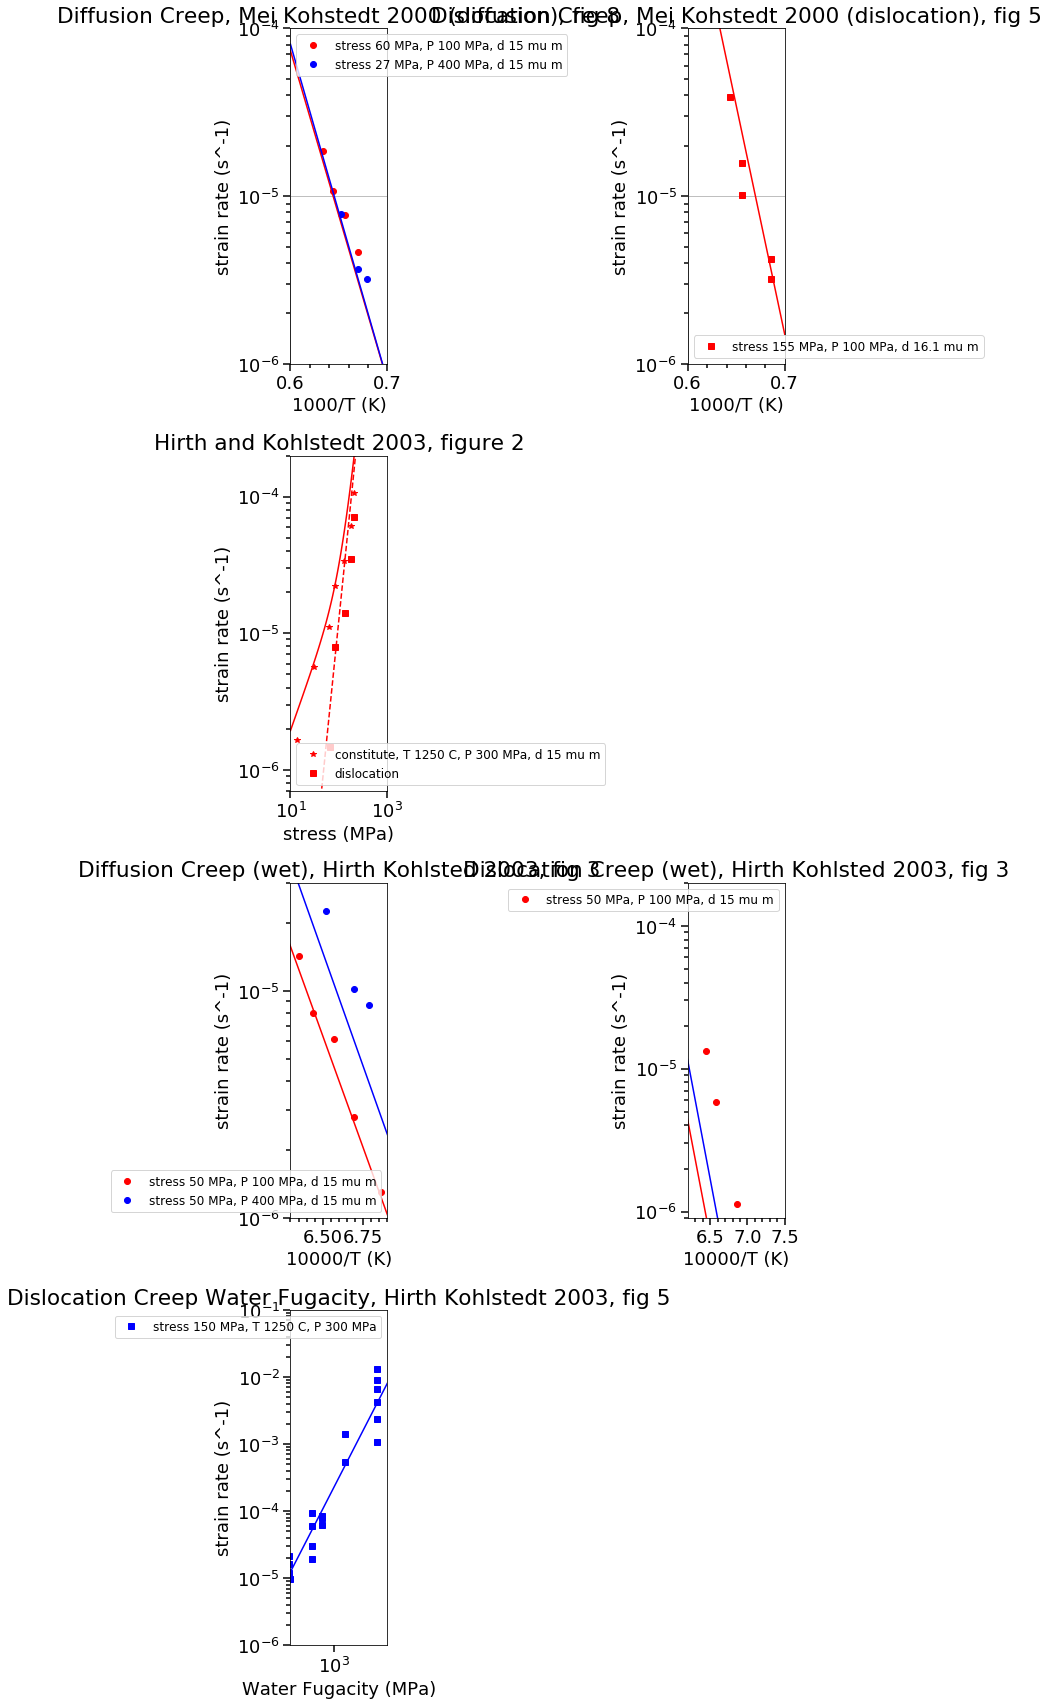

In [4]:
# parse parameters
# the deviations to the activation energies and activation volumes.
by_diff = True

# The default values from Magali's modified version of the HK03 rheology
E_diff = 375e3
V_diff = 23e-6
E_disl = 520e3
V_disl = 24e-6

if by_diff:
    # assign value differences here
    # diffusion creep, the range of deviations is in the comments
    dE_diff = 0.0  # 50e3 + r * 2e3
    dV_diff = 0.0  # 4.5e-6 + r * 1e-6
    # dislocation creep
    dE_disl = 0.0  # 40e3 + r * 2e3
    dV_disl = 0.0  # 3.0e-6 + r * 1e-6

    E_diff += dE_diff
    V_diff += dV_diff
    E_disl += dE_disl
    V_disl += dV_disl
else:
    # assign new values here
    E_diff = 375e3
    V_diff = 23e-6
    E_disl = 520e3
    V_disl = 24e-6

# read the parameters from HK 03.
# water is in the water fugacity
diffusion_creep, dislocation_creep = Rheology.GetRheology("HK03_f", use_coh=False)
rheology_dict = {'diffusion': diffusion_creep, 'dislocation': dislocation_creep}

# Make the output directory
output_dir = os.path.join(RESULT_DIR, "HK03Modify_diff_%.0f_%.0f_disl_%.0f_%.0f" %\
(E_diff/1e3, V_diff*1e6, E_disl/1e3, V_disl*1e6))
if os.path.isdir(output_dir):
    rmtree(output_dir)
os.mkdir(output_dir)

# plot the old result
Rheology.RefitHK03(rheology_dict, "HK03_f", output_dir)

# fit new rheology
stress = 50.0 # MPa
P = 100.0e6 # Pa
T = 1250.0 + 273.15 # K
fh2o = 100.0 # MPa
d = 15.0 # mu m
diffusion_creep_new = RheologyUpdateEV(diffusion_creep, stress, P, T, d, fh2o,\
                                        E=E_diff, V=V_diff)
dislocation_creep_new = RheologyUpdateEV(dislocation_creep, stress, P, T, d, fh2o,\
                                        E=E_disl, V=V_disl)
rheology_new_dict = {'diffusion': diffusion_creep_new, 'dislocation': dislocation_creep_new}

# print the new rheology in dict
print("rheology_new_dict: ", rheology_new_dict)

# plot the new results 
Rheology.RefitHK03(rheology_new_dict, "HK03_f_refit", output_dir)

### Modify the profactor by a constant factor

The prefactors from the previous step are decreased by 3.5 from the issue of water calibration mentioned in Bell et al., 2003.


In [5]:
rheology_modified_dict = rheology_new_dict.copy()
rheology_modified_dict['diffusion']['A'] /= 3.5
rheology_modified_dict['dislocation']['A'] /= 3.5

### Convert from using fugacity to using Coh

The rheology from the previous step is formulated by constant fugacity.
In The next step, we convert the rheology to a formulation by constant Coh.
The flow law parameters of water are (implicit in the module loaded):

    "A" : 87.75,             # H/(10^6*Si)/MPa
    "E" : 50e3,                     # J/mol +/-2e3
    "V" : 10.6e-6                     # m^3/mol+/-1

This operation is handled by the following function:

    ConvertFCoh(creep)

In [6]:
def ConvertFCoh(creep):
    '''
    Convert from using the fugacity to the Coh in the flow law.
    Inputs:
        creep: a set of variables including p, r, n, E, V, the fH2O is used in the flow law.
    
    Returns:
        creep_new: a new set of variables after updating, the COH is used in the flow law.
    '''
    # initiate the class object
    RheologyPrm = Rheology.RHEOLOGY_PRM()
    water_creep = getattr(RheologyPrm, "water")
    creep_new = creep.copy()

    # compute the new A, V, E values
    creep_new['A'] = creep['A'] / (water_creep['A'] ** creep['r'])
    creep_new['V'] = creep['V'] - water_creep['V'] * creep['r']
    creep_new['E'] = creep['E'] - water_creep['E'] * creep['r']

    # remove the use_f flag
    creep_new.pop('use_f')
    return creep_new

In [7]:
# convert to using coh 
diffusion_creep_new = rheology_modified_dict['diffusion']
diffusion_creep_new_coh = ConvertFCoh(diffusion_creep_new)
dislocation_creep_new = rheology_modified_dict['dislocation']
dislocation_creep_new_coh = ConvertFCoh(dislocation_creep_new)

### Format the parameter table

The flow law variables are exported as a latex table which is ready to be imported to a overleaf document.

In [8]:
# generate the table contents for the refitted rheology
#   1. table with unit of fh2o
header, data_diff = Rheology.RheologyTableFormating(diffusion_creep_new, "HK03 diffusion", format="HK03")
_, data_disl = Rheology.RheologyTableFormating(dislocation_creep_new, "HK03 dislocation", format="HK03")
TexTable = Utilities.TEX_TABLE("table-HK03",\
                                header=header, data=data_diff) # class initiation
TexTable.append_data(data_disl)
#   2. table with unit of coh
_, data_diff_coh = Rheology.RheologyTableFormating(diffusion_creep_new_coh, "HK03 diffusion", format="HK03")
_, data_disl_coh = Rheology.RheologyTableFormating(dislocation_creep_new_coh, "HK03 dislocation", format="HK03")
TexTable.append_data(data_diff_coh)
TexTable.append_data(data_disl_coh)
#   3. generate the table contents
table_contents = TexTable(format="latex", fix_underscore_in_content=False) # call function to generate the table

### Convert to parameters in ASPECT by constant Coh values

The follow code block coverts the rheology to parameters in ASPECT by constant Coh values.
The effects of the Coh term will be merged with a new prefactor in U/I unit.

Values of Coh need to be assigned in H / 10^6 Si.
An array could be given and each value would be parsed by the code to be an individual parameter set ready to be imported to an ASPECT .prm file.
A mantle profile is then generated with a reference T profile from ASPECT (potential temperature 1573 K).

In [9]:
# assign values of Coh
# these values of Cohs are then used in rheologies with
# constant Coh values
Cohs = [100.0, 300.0, 1000.0]  # H/10^6 Si

# parameters for ASPECT & plot a figure of the upper mantle viscosity
Operator = Rheology.RHEOLOGY_OPR()
# read profile
source_dir = os.path.join(ASPECT_LAB_DIR, 'tests', 'integration', 'fixtures', 'test_rheology')
file_path = os.path.join(source_dir, "depth_average.txt")
assert(os.path.isfile(file_path))
Operator.ReadProfile(file_path)
header, _ = Rheology.RheologyTableFormating({}, "", format="aspect", header_only=True) # generate header
TexTable = Utilities.TEX_TABLE("table-aspect", header=header) # class initiation
for Coh in Cohs: 
    fig_path = os.path.join(output_dir, "mantle_profile_Coh_%.0f.png" % Coh)
    # loop values of Coh & use 600 as plotting depth to not plot the jump on the 660
    rheology_aspect, _ = Operator.MantleRheology(assign_rheology=True, diffusion_creep=diffusion_creep_new_coh,\
        dislocation_creep=dislocation_creep_new_coh, Coh=Coh, save_profile=True, ymax=600.0,\
        use_effective_strain_rate=True, save_json=False, fig_path=fig_path)
    # generate the table contents for aspect rheology prm file
    diffusion_creep_aspect = rheology_aspect['diffusion_creep']
    dislocation_creep_aspect = rheology_aspect['dislocation_creep']
    _, data_diff = Rheology.RheologyTableFormating(diffusion_creep_aspect, "ASPECT diffusion (Coh=%.1f)" % Coh, format="aspect")
    _, data_disl = Rheology.RheologyTableFormating(dislocation_creep_aspect, "ASPECT dislocation (Coh=%.1f)" % Coh, format="aspect")
    TexTable.append_data(data_diff)
    TexTable.append_data(data_disl)
table_contents += "\n"
table_contents += TexTable(format="latex", fix_underscore_in_content=False) # call function to generate the table

# write the table 
file_out = os.path.join(output_dir, "rheology_latex_table.tex")
with open(file_out, 'w') as fout:
    fout.write(table_contents)
print("%s: table %s generated." % (Utilities.func_name(), file_out))

New figure: /home/lochy/ASPECT_PROJECT/aspectLib/results/HK03Modify_diff_375_23_disl_520_24/mantle_profile_Coh_100.png
New figure: /home/lochy/ASPECT_PROJECT/aspectLib/results/HK03Modify_diff_375_23_disl_520_24/mantle_profile_Coh_300.png
New figure: /home/lochy/ASPECT_PROJECT/aspectLib/results/HK03Modify_diff_375_23_disl_520_24/mantle_profile_Coh_1000.png
<module>: table /home/lochy/ASPECT_PROJECT/aspectLib/results/HK03Modify_diff_375_23_disl_520_24/rheology_latex_table.tex generated.
